In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans

In [3]:
def show(img):
    plt.imshow(img, cmap="gray")
    plt.show()

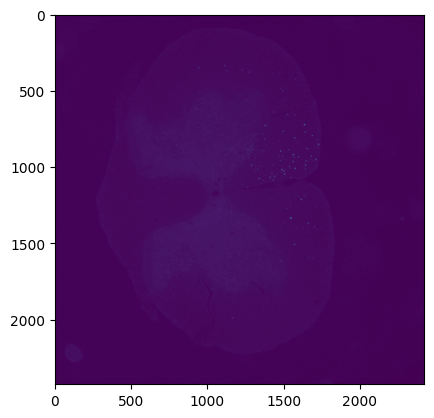

In [52]:
im = cv2.imread("Parts/B1-12/4x bda.tif", 0)
sh = im.shape
plt.imshow(im)
plt.show()

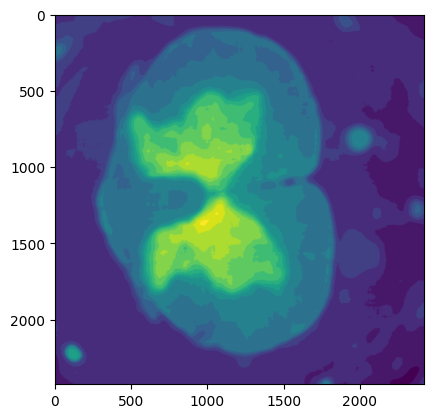

In [53]:
median = cv2.medianBlur(im,65)
plt.imshow(median)

In [4]:
def apply_nonlinear_correction(image):
    float_image = image.astype(np.float32) / 255.0
    
    corrected_image = np.sqrt(float_image)
    
    # Convertir la imagen de vuelta a formato de 8 bits
    corrected_image = (corrected_image * 255).astype(np.uint8)
    
    return corrected_image

def train(pixels, num_clusters):

    # Aplicar el algoritmo K-means
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=2023)
    kmeans.fit(pixels)
    return kmeans

def segment_image(pixels, kmeans):

    # Asignar etiquetas a los píxeles
    labels = kmeans.predict(pixels)
    
    # Crear una imagen de segmentación a partir de las etiquetas
    segmented_image = labels.reshape(image.shape)
    
    return segmented_image

In [26]:
# Ruta de la imagen a segmentar
image_path = "Representatives/C4-BJZ5.tiff"

# Número de clusters (segmentos) deseados
num_clusters = 3
kmeans = train(image_path, num_clusters)

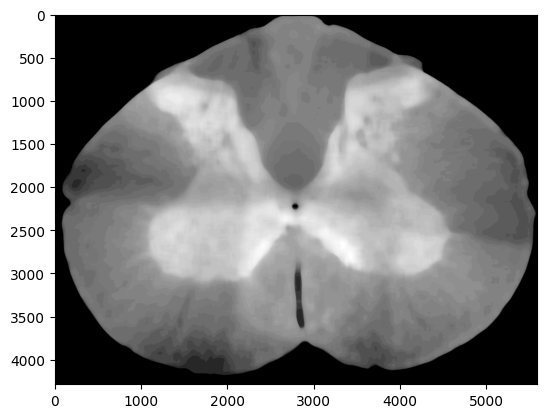

ValueError: X has 1 features, but KMeans is expecting 5595 features as input.

In [34]:
# Segmentar la imagen
segmented_image = segment_image(image_path, kmeans)

show(segmented_image)

In [83]:
kernel = np.ones((100,100),np.uint8)
s_g_o = cv2.morphologyEx(s_g.astype(np.uint8), cv2.MORPH_OPEN, kernel)

kernel = np.ones((200,200),np.uint8)
s_g_c = cv2.morphologyEx(s_g_o.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

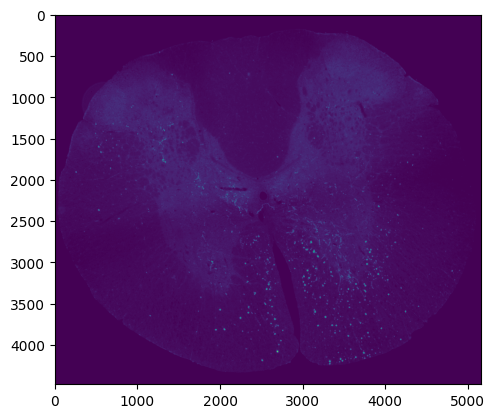

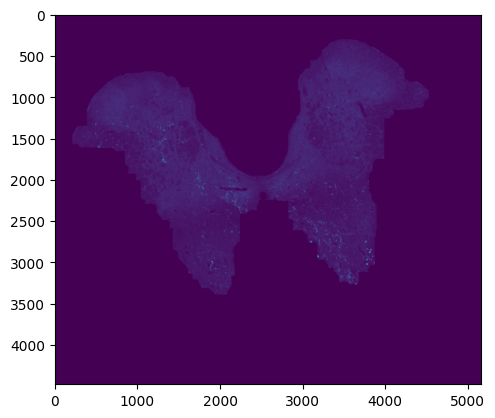

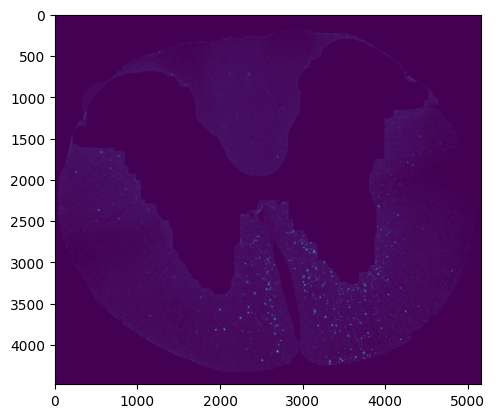

In [84]:
im = cv2.imread(image_path, 0)
s_b = im*(1-s_g_c)
s_g = im*s_g_c
plt.imshow(im)
plt.show()

plt.imshow(s_g)
plt.show()

plt.imshow(s_b)
plt.show()

In [42]:
ims = os.listdir("Representatives")

# Número de clusters (segmentos) deseados
num_clusters = 3

pixels = np.array([])
for imagen in ims[:2]:
    # Ruta de la imagen a segmentar
    image_path = "Representatives/"+imagen
    
    image = cv2.imread(image_path, 0)
    corrected_image = apply_nonlinear_correction(image)
    image = cv2.medianBlur(corrected_image, 105)
    # Redimensionar la imagen para obtener una matriz 2D de píxeles
    pix = image.flatten()
    pixels = np.concatenate((pixels, pix))
pixels = pixels.astype(np.uint8)

In [37]:
print(pixels.reshape(-1, 1))

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [62]:
image_path = "Representatives/C1-BJZ5.tiff"
    
image = cv2.imread(image_path, 0)
corrected_image = apply_nonlinear_correction(image)
image = cv2.medianBlur(corrected_image, 205)

kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=2023)
kmeans.fit(pixels.reshape(-1, 1))

KMeans(n_clusters=3, n_init=10, random_state=2023)

In [74]:
ims = os.listdir("Representatives")
seg_images = []
for imagen in ims:
    # Ruta de la imagen a segmentar
    image_path = "Representatives/"+imagen
        
    image = cv2.imread(image_path, 0)
    corrected_image = apply_nonlinear_correction(image)
    image = cv2.medianBlur(corrected_image, 205)
    pix = image.reshape(-1, 1)
    # Asignar etiquetas a los píxeles
    labels = kmeans.predict(pix)

    # Crear una imagen de segmentación a partir de las etiquetas
    segmented_image = labels.reshape(image.shape)
    seg_images.append(segmented_image)

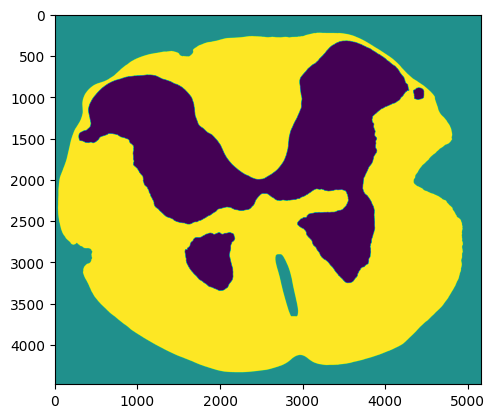

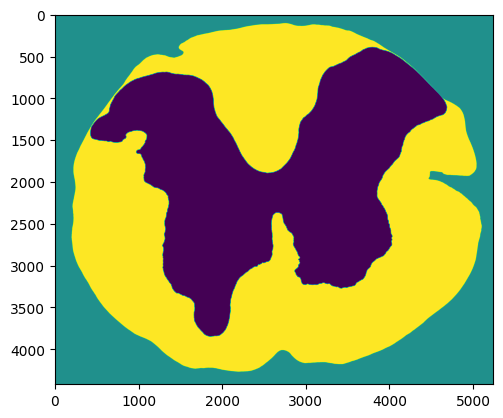

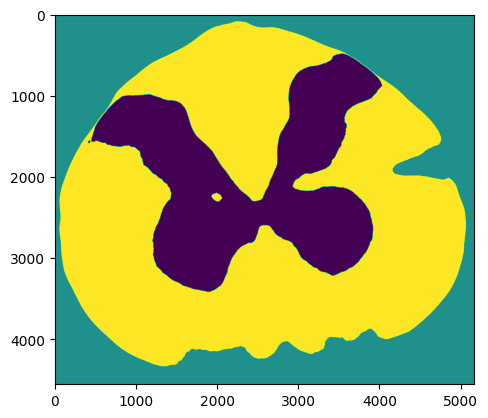

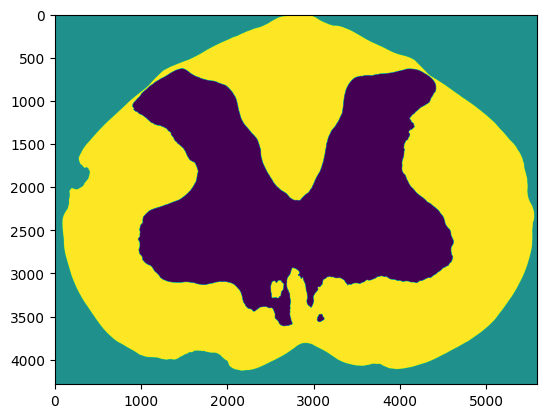

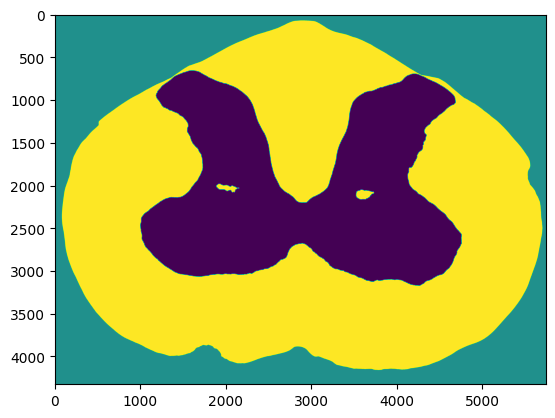

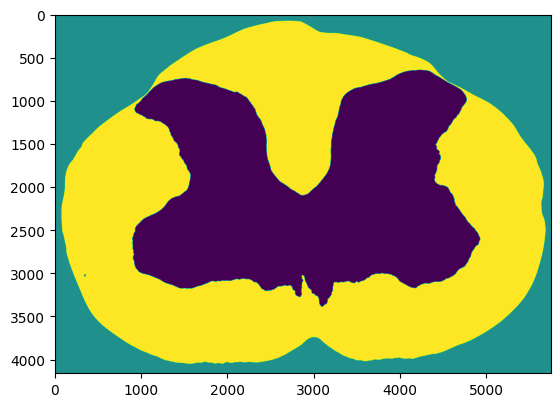

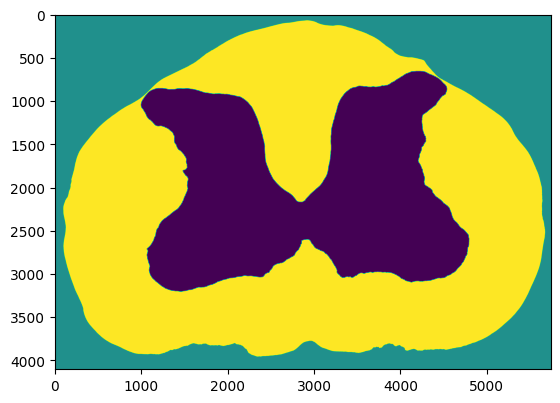

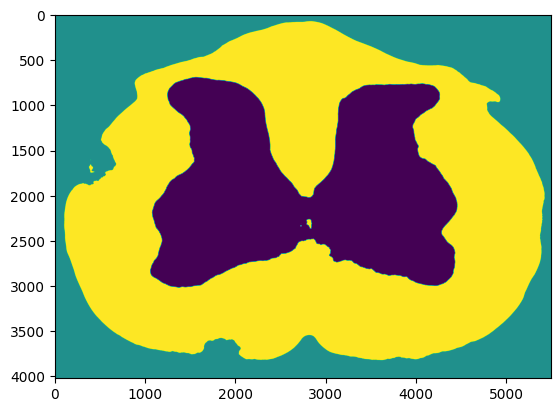

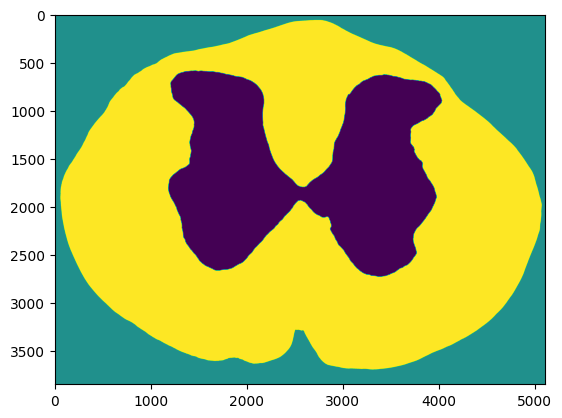

In [75]:
for seg in seg_images:
    plt.imshow(seg)
    plt.show()

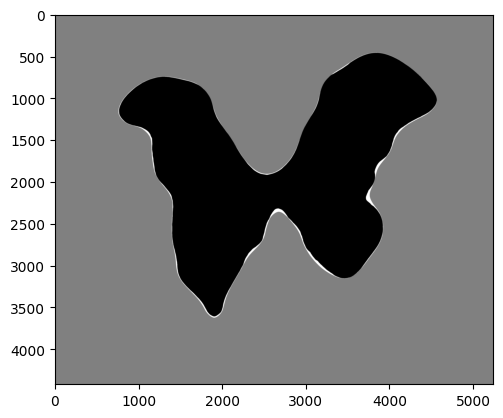

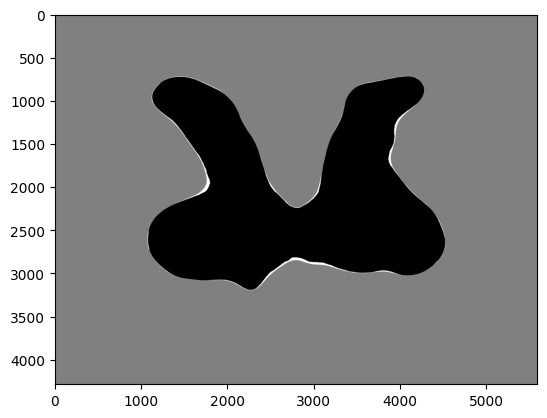

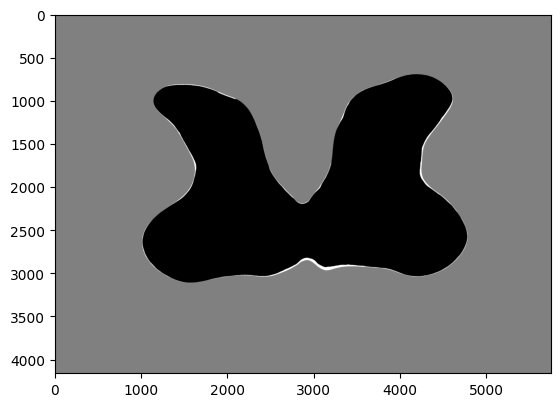

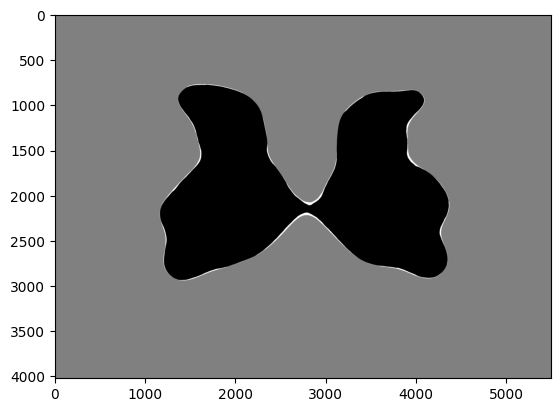

In [84]:
repete = [1, 3, 5, 7]
ims_name = os.listdir("Representatives")
for r in repete:
    img = cv2.imread("Representatives/" + ims_name[r], 0)
    
    mask = (seg_images[r]==0)
    kernel = np.ones((300,300),np.uint8)
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    image = img * mask
    if(r in repete):
        for i in range(6):
            corrected_image = apply_nonlinear_correction(image)
            image = cv2.medianBlur(corrected_image, 205)
            pix = image.reshape(-1, 1)
            # Asignar etiquetas a los píxeles
            labels = kmeans.predict(pix)
            segmented_image = labels.reshape(image.shape)
            
            image = img * (segmented_image==0)

    seg_images[r] = segmented_image
    

In [85]:

ims_name = os.listdir("Representatives")
for i, ims in enumerate(seg_images):
    s_g = ims==0
    im_name = ims_name[i]

    kernel = np.ones((200,200),np.uint8)
    s_g_o = cv2.morphologyEx(s_g.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    img = cv2.imread("Representatives/"+im_name, 0)
    #img = apply_nonlinear_correction(img)
    s_b = img*(1-s_g_o)
    s_g = img*s_g_o
    cv2.imwrite("S_blanca/"+im_name, s_b)